In [1]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import importlib
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
import pydicom
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
from os import path
from yolo3.yolo3 import YOLO

c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

In [3]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
                #print('\n',annotation_lines[i],input_shape)                
            image, box = get_random_data(annotation_lines[i], input_shape, random=False,max_boxes=4)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

In [4]:
def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

In [5]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

In [6]:
ss=800
annotation_path = 'train.txt'
log_dir = 'logs/004/'
classes_path='player_classes.txt'
class_names = get_classes(classes_path)
print(class_names)
num_classes = 1
YOLO_ANCHORS = np.array(
    ((0.7389  , 0.2602), (0.3653, 0.2258), (0.1903  , 0.1437),
     (0.1903 , 0.1352), (0.2278, 0.1078),(0.3097   ,0.0750),
    (0.1514 , 0.1383),(0.1546 ,  0.0836),(0.1083, 0.0766)))
anchors = YOLO_ANCHORS*ss
anchors_number = YOLO_ANCHORS.shape[0]
anchors=anchors[[8,7,6,5,4,3,2,1,0],:]
#print(anchors)

['o']


In [7]:
input_shape = (ss,ss)
model = create_model(input_shape, anchors, num_classes,
            freeze_body=2, weights_path='model_data/yolo_weights.h5')

Create YOLOv3 model with 9 anchors and 1 classes.


c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\keras\engine\topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 18) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\keras\engine\topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((18,) vs (255,)).
  weight_values[i].shape))
c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\keras\engine\topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 18) vs (255, 512, 1, 1)).
  weight_values[i].shape))
c:\users\popeye\appdata\local\programs\python\python35\lib\site-packages\keras\engine\topology.py:3473: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((18,) vs (255,)).
  weight_values[i].shape))
c:\users\popey

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.


In [8]:
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

In [9]:
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(42)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

In [10]:
model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

In [11]:
batch_size = 4
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=30,
        initial_epoch=0,
        callbacks=[logging, checkpoint])
model.save_weights(log_dir + 'trained_weights_stage_1.h5')

Train on 23116 samples, val on 2568 samples, with batch size 4.
Epoch 1/30
5779/5779 [==============================] - 3136s 543ms/step - loss: 77.0333 - val_loss: 14.5260
Epoch 2/30
5779/5779 [==============================] - 3159s 547ms/step - loss: 14.0212 - val_loss: 14.2659
Epoch 3/30
5779/5779 [==============================] - 3161s 547ms/step - loss: 13.8159 - val_loss: 14.4639
Epoch 4/30
5779/5779 [==============================] - 3160s 547ms/step - loss: 13.8000 - val_loss: 14.6002
Epoch 5/30
5779/5779 [==============================] - 3163s 547ms/step - loss: 13.7261 - val_loss: 14.5925
Epoch 6/30
5779/5779 [==============================] - 3167s 548ms/step - loss: 13.7349 - val_loss: 14.6267
Epoch 7/30
5779/5779 [==============================] - 3158s 546ms/step - loss: 13.7397 - val_loss: 14.9639
Epoch 8/30
5779/5779 [==============================] - 3164s 548ms/step - loss: 13.7204 - val_loss: 14.4871
Epoch 9/30
5779/5779 [==============================] - 3164s 54

KeyboardInterrupt: 

In [12]:
import yolo3.yolo3
importlib.reload(yolo3.yolo3)
from yolo3.yolo3 import YOLO

In [13]:
yolo_class=YOLO(log_dir,'', ss)

logs/004/trained_weights_final.h5
Exception... logs/004/trained_weights_final.h5 False 1 9
logs/004/trained_weights_final.h5 model, anchors, and classes loaded.


In [16]:
input_shape = (ss,ss)

In [17]:
res=[]
for i in range(100):
    l1 = lines[i]
    l2 = l1.split()
    d = pydicom.read_file(l2[0])
    image = d.pixel_array.astype('uint8')
    image = np.stack((image,)*3,-1)
    im = cv2.resize(image,(ss, ss)) 
    r_image,box,score = yolo_class.detect_image(im.astype('uint8'))   
    res.append(r_image)

Found 2 boxes for img
Time:  2.2939512468346335
Found 0 boxes for img
Time:  0.1622008969211337
Found 0 boxes for img
Time:  0.1604951074206502
Found 2 boxes for img
Time:  0.16291717947985562
Found 0 boxes for img
Time:  0.17758808692012762
Found 2 boxes for img
Time:  0.15912960646995344
Found 0 boxes for img
Time:  0.1611229025371368
Found 1 boxes for img
Time:  0.15883371688241033
Found 1 boxes for img
Time:  0.15876478982214337
Found 0 boxes for img
Time:  0.16013277463086784
Found 2 boxes for img
Time:  0.16179944336741592
Found 0 boxes for img
Time:  0.15963817640111344
Found 2 boxes for img
Time:  0.16322486739302988
Found 1 boxes for img
Time:  0.1607894445969258
Found 1 boxes for img
Time:  0.1624210288388337
Found 1 boxes for img
Time:  0.16185688258430453
Found 1 boxes for img
Time:  0.1609642461056211
Found 1 boxes for img
Time:  0.1651585508675497
Found 2 boxes for img
Time:  0.16455373143781848
Found 2 boxes for img
Time:  0.1637672798898162
Found 2 boxes for img
Time:  

KeyboardInterrupt: 

Found 0 boxes for img
Time:  2.319042870147628
[[625 546 925 727   0]]
625 546 925 727
Found 0 boxes for img
Time:  0.15914823540516077
[]
Found 0 boxes for img
Time:  0.15945716524734888
[]
Found 0 boxes for img
Time:  0.15997225530583137
[]
Found 0 boxes for img
Time:  0.1610052297630773
[]
Found 0 boxes for img
Time:  0.1591814570062806
[]
Found 0 boxes for img
Time:  0.17244681128516026
[]
Found 0 boxes for img
Time:  0.15887066427057128
[]
Found 0 boxes for img
Time:  0.16075901733608688
[]
Found 0 boxes for img
Time:  0.17340868530636477
[[263 307 452 479   0]]
263 307 452 479


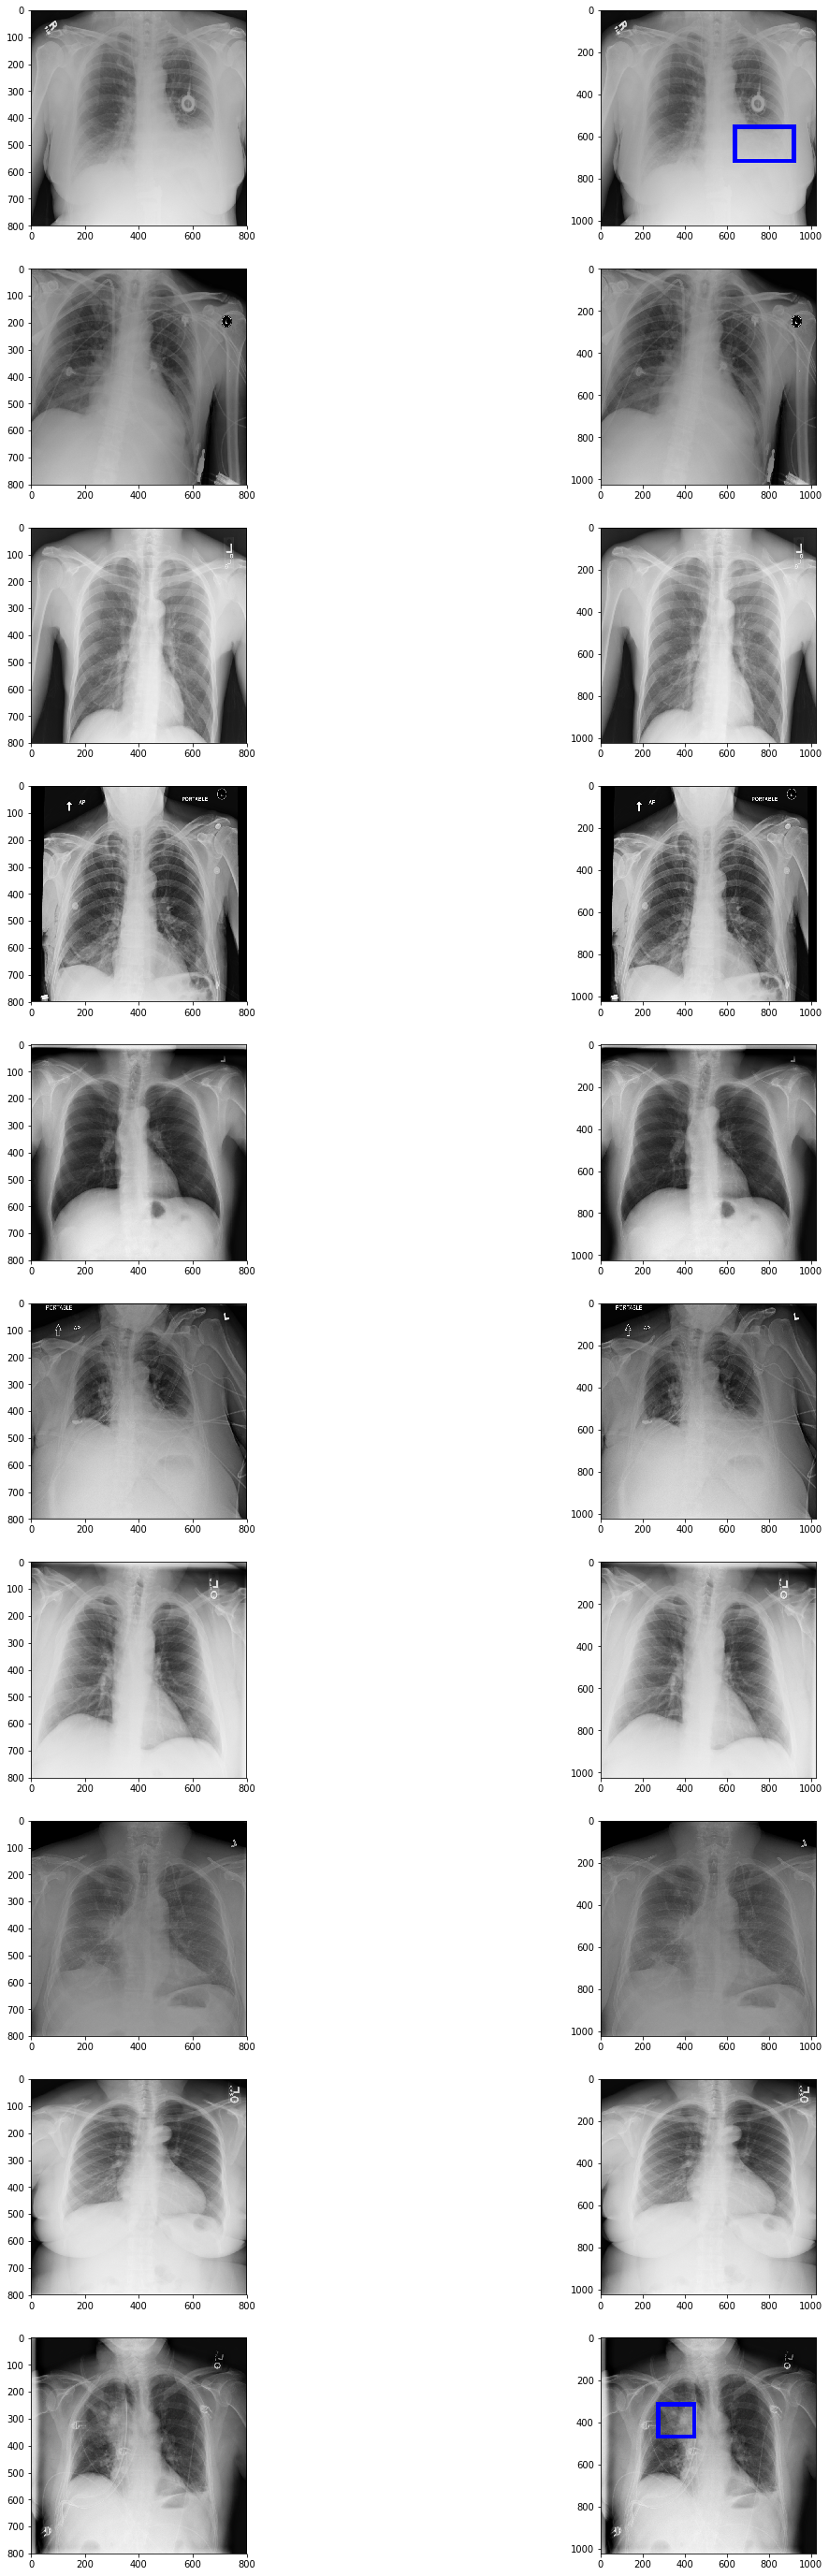

In [14]:
thickness = 20
f, axs = plt.subplots(10,2,figsize=(20,50))
for i in range(10):
    l1 = lines[i+num_train]
    l2 = l1.split()
    d = pydicom.read_file(l2[0])
    image = d.pixel_array.astype('uint8')
    image = np.stack((image,)*3,-1)
    im = cv2.resize(image,(ss, ss)) 
    r_image,box,score = yolo_class.detect_image(im.astype('uint8')) 
    img = Image.fromarray(r_image,'RGB')
    plt.subplot(10,2,i*2+1)
    plt.imshow(img)

    image=Image.fromarray(image,'RGB')
    draw = ImageDraw.Draw(image)
    box = np.array([np.array(list(map(int,box.split(',')))) for box in l2[1:]])
    print(box)
    for jj in range(box.shape[0]):
        left, top, right, bottom, dummy = box[jj,:]
        print(left,top,right,bottom)
        for j in range(thickness):
            draw.rectangle(
                [left + j, top + j, right - j, bottom - j],
                outline='blue')
    del draw
    plt.subplot(10,2,i*2+2)
    plt.imshow(image)
plt.show()

In [58]:
box

array([], shape=(0, 4), dtype=float32)

In [15]:
df = pd.read_csv('input/stage_1_sample_submission.csv')
submit_file_path = "submission1.csv"
submit_dict = {"patientId": [], "PredictionString": []}

for i in range(len(df)):
    patient_id = df['patientId'][i]
    d = pydicom.read_file(path.join('input','stage_1_test_images', patient_id +'.dcm'))
    image = d.pixel_array.astype('uint8')
    image = np.stack((image,)*3,-1)
    im = cv2.resize(image,(ss, ss)) 
    r_image,box,score = yolo_class.detect_image(im.astype('uint8'))  
    box = box *  image.shape[0]/ ss       
    submit_line = ""
    for e in range(box.shape[0]):
        confi = score[e]
        w = box[e,3]-box[e,1]
        h = box[e,2]-box[e,0]
        x = box[e,1]
        y = box[e,0]
        submit_line += "{} {} {} {} {} ".format(confi, x, y, w, h)

    submit_dict["patientId"].append(patient_id)
    submit_dict["PredictionString"].append(submit_line)

Found 0 boxes for img
Time:  0.1868668490646357
Found 0 boxes for img
Time:  0.16752970383718946
Found 0 boxes for img
Time:  0.17203697471060053
Found 0 boxes for img
Time:  0.16474467802369475
Found 0 boxes for img
Time:  0.16007378300271569
Found 0 boxes for img
Time:  0.16425194268745713
Found 0 boxes for img
Time:  0.1626784186269532
Found 0 boxes for img
Time:  0.16243127475319596
Found 0 boxes for img
Time:  0.174527663347817
Found 0 boxes for img
Time:  0.1591718320564226
Found 0 boxes for img
Time:  0.16454348552345266
Found 0 boxes for img
Time:  0.17292060720393465
Found 0 boxes for img
Time:  0.160107315086087
Found 0 boxes for img
Time:  0.16178112491446228
Found 0 boxes for img
Time:  0.1640656533353848
Found 0 boxes for img
Time:  0.1623822185571555
Found 0 boxes for img
Time:  0.1639467386323119
Found 0 boxes for img
Time:  0.17303641708447515
Found 0 boxes for img
Time:  0.16147219507227817
Found 0 boxes for img
Time:  0.1650355998951838
Found 0 boxes for img
Time:  0.

Time:  0.1597878288472856
Found 0 boxes for img
Time:  0.16444226830883224
Found 0 boxes for img
Time:  0.1693851457838349
Found 0 boxes for img
Time:  0.16631168195688417
Found 0 boxes for img
Time:  0.1622223201966193
Found 0 boxes for img
Time:  0.16083943223972597
Found 0 boxes for img
Time:  0.16176808465982617
Found 0 boxes for img
Time:  0.16030043504773062
Found 0 boxes for img
Time:  0.1673949545391764
Found 0 boxes for img
Time:  0.16445779242150138
Found 0 boxes for img
Time:  0.15870300385370228
Found 0 boxes for img
Time:  0.16085650876367197
Found 0 boxes for img
Time:  0.16541221486862412
Found 0 boxes for img
Time:  0.15850802099853922
Found 0 boxes for img
Time:  0.1623617267284203
Found 0 boxes for img
Time:  0.16632192787125177
Found 0 boxes for img
Time:  0.1646580534749802
Found 0 boxes for img
Time:  0.1628584983339607
Found 0 boxes for img
Time:  0.1588042210683227
Found 0 boxes for img
Time:  0.15844281972532315
Found 0 boxes for img
Time:  0.1561384204401719
Fo

Found 0 boxes for img
Time:  0.16153180766494302
Found 0 boxes for img
Time:  0.17880766121170666
Found 0 boxes for img
Time:  0.1632459801862609
Found 0 boxes for img
Time:  0.16135731663850095
Found 0 boxes for img
Time:  0.16584689002345954
Found 0 boxes for img
Time:  0.16706149659897562
Found 0 boxes for img
Time:  0.1666712204063856
Found 0 boxes for img
Time:  0.1647126983515932
Found 0 boxes for img
Time:  0.16896785763519517
Found 0 boxes for img
Time:  0.16380236438445195
Found 0 boxes for img
Time:  0.17284888580338986
Found 0 boxes for img
Time:  0.1599036387278261
Found 0 boxes for img
Time:  0.15917586832571828
Found 0 boxes for img
Time:  0.16227944893125823
Found 0 boxes for img
Time:  0.16420971710098797
Found 0 boxes for img
Time:  0.16601392947582383
Found 0 boxes for img
Time:  0.16396505708526377
Found 0 boxes for img
Time:  0.16091487942730964
Found 0 boxes for img
Time:  0.16675846591959953
Found 0 boxes for img
Time:  0.16460961824344622
Found 0 boxes for img
Ti

Found 0 boxes for img
Time:  0.16449567125641806
Found 0 boxes for img
Time:  0.16726393102823067
Found 0 boxes for img
Time:  0.1651812160720567
Found 0 boxes for img
Time:  0.16178671359503483
Found 0 boxes for img
Time:  0.1668950781111107
Found 0 boxes for img
Time:  0.16350026515183913
Found 0 boxes for img
Time:  0.16051963551868198
Found 0 boxes for img
Time:  0.1601750002173219
Found 0 boxes for img
Time:  0.16394580718554153
Found 0 boxes for img
Time:  0.16380546920697725
Found 0 boxes for img
Time:  0.16377100567686398
Found 0 boxes for img
Time:  0.16627225071070484
Found 0 boxes for img
Time:  0.16316556528261117
Found 0 boxes for img
Time:  0.16313669043304913
Found 0 boxes for img
Time:  0.16309136002402624
Found 0 boxes for img
Time:  0.1681202410832725
Found 0 boxes for img
Time:  0.16445158277645078
Found 0 boxes for img
Time:  0.16577175331812555
Found 0 boxes for img
Time:  0.16558049625001559
Found 0 boxes for img
Time:  0.16466022685074222
Found 0 boxes for img
Ti

Found 0 boxes for img
Time:  0.16230832378082027
Found 0 boxes for img
Time:  0.1604339424167165
Found 0 boxes for img
Time:  0.16402963739398047
Found 0 boxes for img
Time:  0.16236452106869592
Found 0 boxes for img
Time:  0.16267438235766463
Found 0 boxes for img
Time:  0.16448325196628844
Found 0 boxes for img
Time:  0.16268307586074116
Found 0 boxes for img
Time:  0.1579541206583599
Found 0 boxes for img
Time:  0.16077485193102348
Found 0 boxes for img
Time:  0.16682832442663198
Found 0 boxes for img
Time:  0.16602448587244112
Found 0 boxes for img
Time:  0.16619307773606806
Found 0 boxes for img
Time:  0.16524207059373452
Found 0 boxes for img
Time:  0.16630267797154374
Found 0 boxes for img
Time:  0.16219779209859553
Found 0 boxes for img
Time:  0.16256602405121612
Found 0 boxes for img
Time:  0.1654609605824362
Found 0 boxes for img
Time:  0.17482479486434954
Found 0 boxes for img
Time:  0.16724033437697017
Found 0 boxes for img
Time:  0.16440345802715228
Found 0 boxes for img
T

Found 0 boxes for img
Time:  0.16109185431179185
Found 0 boxes for img
Time:  0.16200684551270683
Found 0 boxes for img
Time:  0.16537495699822102
Found 0 boxes for img
Time:  0.16314321056037784
Found 0 boxes for img
Time:  0.16208539752284423
Found 0 boxes for img
Time:  0.1642292774829741
Found 0 boxes for img
Time:  0.1611033421551724
Found 0 boxes for img
Time:  0.1643649582277078
Found 0 boxes for img
Time:  0.16455031613301685
Found 0 boxes for img
Time:  0.16310191642065774
Found 0 boxes for img
Time:  0.17002411826146613
Found 0 boxes for img
Time:  0.17069910668044486
Found 0 boxes for img
Time:  0.16521040140386845
Found 0 boxes for img
Time:  0.16439755886435137
Found 0 boxes for img
Time:  0.16409918541876323
Found 0 boxes for img
Time:  0.1617506976536447
Found 0 boxes for img
Time:  0.1620018777966834
Found 0 boxes for img
Time:  0.16595431688315898
Found 0 boxes for img
Time:  0.16230925522759776
Found 0 boxes for img
Time:  0.162192513900294
Found 0 boxes for img
Time:

In [16]:
sdf = pd.DataFrame(submit_dict)
sdf = sdf[['patientId','PredictionString']]
sdf.to_csv(submit_file_path, index=False)

In [84]:
f, axs = plt.subplots(10,1,figsize=(10,50))
for i in range(10):
    patient_id = df['patientId'][i]
    d = pydicom.read_file(path.join('input','stage_1_test_images', patient_id +'.dcm'))
    image = d.pixel_array.astype('uint8')
    image = np.stack((image,)*3,-1)
    im = cv2.resize(image,(ss, ss)) 
    r_image,box,score = yolo_class.detect_image(im.astype('uint8'))     
    submit_line = ""
    for e in range(box.shape[0]):
        confi = score[e]
        w = box[e,3]-box[e,1]
        h = box[e,2]-box[e,0]
        x = box[e,1]
        y = box[e,0]
        submit_line += "{} {} {} {} {} ".format(confi, x, y, w, h)
    img = Image.fromarray(r_image,'RGB')
    plt.subplot(10,1,i+1)
    plt.imshow(img)
    #submit_dict["patientId"].append(patient_id)
    #submit_dict["PredictionString"].append(submit_line)
plt.show() 

Found 0 boxes for img
Time:  0.1699362517838381
Found 1 boxes for img
Time:  0.16660912395582272
Found 2 boxes for img
Time:  0.17069413896388141
Found 1 boxes for img
Time:  0.15816649051976128
Found 0 boxes for img
Time:  0.17595060351595748
Found 0 boxes for img
Time:  0.17342514086521987
Found 2 boxes for img
Time:  0.1587831082752018
Found 0 boxes for img
Time:  0.17613813479692908
Found 0 boxes for img
Time:  0.16457111844374595
Found 1 boxes for img
Time:  0.1623170172842947


<function matplotlib.pyplot.show>

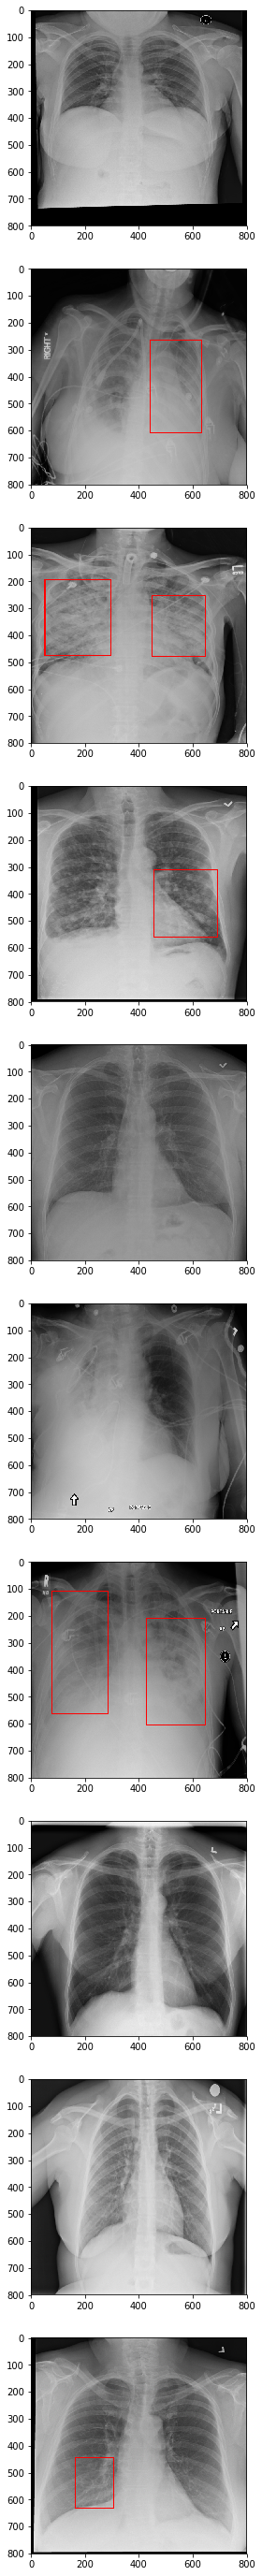

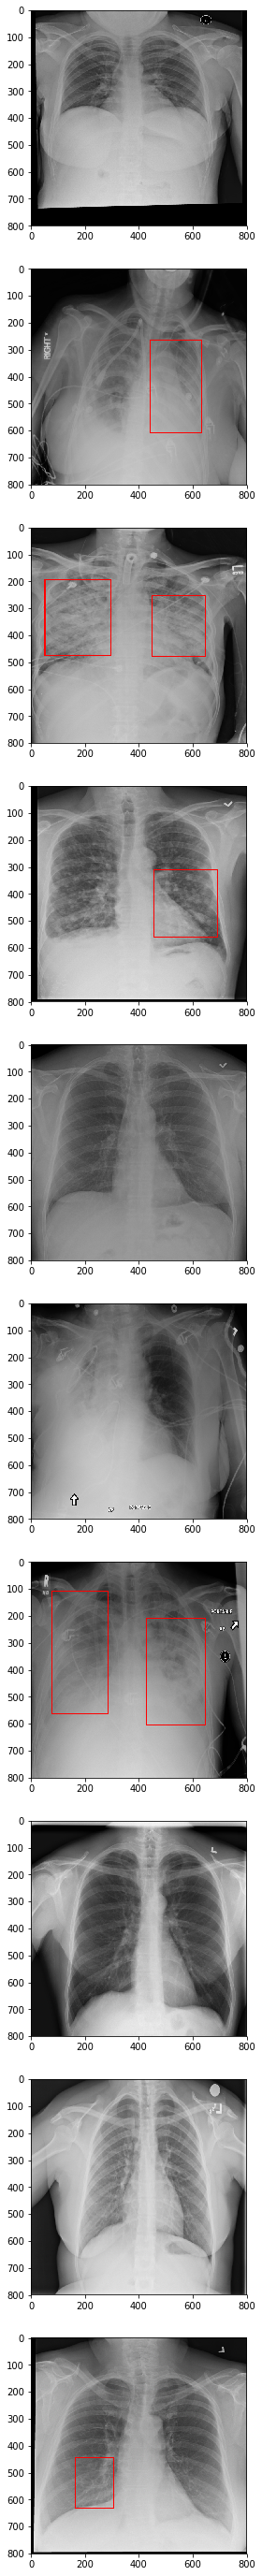

In [85]:
plt.show()

In [ ]:
# from keras import backend as K
# from yolo3.model import yolo_eval
# sess = K.get_session()
# image_data = im/255.
# image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
# print(image_data.shape)

# boxes, scores, classes = yolo_eval(model.output, anchors,
#         1,input_shape,4,
#         score_threshold= 0.3, iou_threshold=0.45)


# out_boxes, out_scores, out_classes = sess.run(
#     [boxes, scores, classes],
#     feed_dict={
#         model.input: image_data,
#         input_image_shape: [ss, ss],
#         K.learning_phase(): 0
#     })

In [88]:
image.shape[0]/ss

1.28

In [89]:
ss

800

In [11]:
model.load_weights(log_dir + 'trained_weights_stage_1.h5')

In [12]:
# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.

for i in range(len(model.layers)):
    model.layers[i].trainable = True
model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
print('Unfreeze all of the layers.')

batch_size = 1 # note that more GPU memory is required after unfreezing the body
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
    steps_per_epoch=max(1, num_train//batch_size),
    validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
    validation_steps=max(1, num_val//batch_size),
    epochs=80,
    initial_epoch=50,
    callbacks=[logging, checkpoint, reduce_lr, early_stopping])
model.save_weights(log_dir + 'trained_weights_final.h5')

# Further training if needed.

Unfreeze all of the layers.
Train on 5094 samples, val on 565 samples, with batch size 1.
Epoch 51/80
5094/5094 [==============================] - 3048s 598ms/step - loss: 22.3318 - val_loss: 20.9374
Epoch 52/80
5094/5094 [==============================] - 3031s 595ms/step - loss: 20.1177 - val_loss: 20.2306
Epoch 53/80
5094/5094 [==============================] - 3029s 595ms/step - loss: 18.4337 - val_loss: 17.8845
Epoch 54/80
5094/5094 [==============================] - 3029s 595ms/step - loss: 16.4936 - val_loss: 16.5959
Epoch 55/80
5094/5094 [==============================] - 3029s 595ms/step - loss: 15.3368 - val_loss: 15.7784
Epoch 56/80
5094/5094 [==============================] - 3030s 595ms/step - loss: 14.2983 - val_loss: 15.8266
Epoch 57/80
5094/5094 [==============================] - 3027s 594ms/step - loss: 13.8518 - val_loss: 16.4383
Epoch 58/80
5094/5094 [==============================] - 3028s 594ms/step - loss: 12.3881 - val_loss: 16.9956

Epoch 00058: ReduceLROnPlatea